In [7]:
import torch
from Nets import Net
from functions import test, train, save_pruned_model
from dataloaders.noise import dataloader_pretraining_gray
from dataloaders.mnist import MNIST
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
import wandb

torch.cuda.is_available()
device = 'cuda'

In [22]:
import torch.nn.functional as F

def train(model, optimizer, train_loader, val_loader = [], epoch = 1, log_interval = 100):
    train_losses = []
    val_losses = []
    exemplers = []
    model.train()
    for e in range(epoch):
        for batch_idx, (data, target) in enumerate(train_loader):
            exemplers.append(train_loader.batch_size * batch_idx)
            optimizer.zero_grad()
            output = model(data)
            loss = F.cross_entropy(output, target)
            loss.backward()
            optimizer.step()
            if batch_idx % log_interval == 0:
                print(f"Epoch {e+1} [{batch_idx * len(data)} / {len(train_loader.dataset)}]       loss: {loss.item()}")
                wandb.log({'train_loss': loss.item()})
            if val_loader and batch_idx % log_interval == 0:
                acc  = test(model, val_loader, print_accuracy=False)
                val_losses.append(acc)
                wandb.log({'val_acc': acc})
            train_losses.append(loss.item())
    return train_losses, val_losses, exemplers

In [3]:
dataset_names = ['dead_leaves-mixed',
 'dead_leaves-oriented',
 'dead_leaves-squares',
 'dead_leaves-textures',
 'stat-spectrum',
 'stat-spectrum_color',
 'stat-spectrum_color_wmm',
 'stat-wmm',
 'stylegan-highfreq',
 'stylegan-random']

accuracy,▁
accuracy,52.96
piwo,test


-------------------------------------------------- training only last layer --------------------------------------------------
Epoch 1 [0 / 50000]       loss: 2.3167812824249268
Epoch 1 [6400 / 50000]       loss: 2.2777657508850098
Epoch 1 [12800 / 50000]       loss: 2.225616455078125
Epoch 1 [19200 / 50000]       loss: 2.2408158779144287
Epoch 1 [25600 / 50000]       loss: 2.1911001205444336
Epoch 1 [32000 / 50000]       loss: 2.210360527038574
Epoch 1 [38400 / 50000]       loss: 2.2284998893737793
Epoch 1 [44800 / 50000]       loss: 2.137115001678467


c:\Users\QbaSo\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.1299, Accuracy: 4695/10000 (47%)



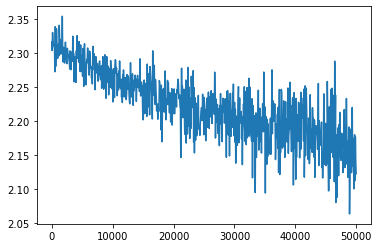

In [23]:
wandb.init(
    # set the wandb project where this run will be logged
    project="pretraining and mnist",
    
    # track hyperparameters and run metadata
    config={
    "setup": "benchmark random weights",
    "learning_rate": 0.1,
    "architecture": "CNN",
    "dataset": "MNIST",
    "epochs": 1,
    }
)

newModel = Net(10)
optimizer = optim.SGD(newModel.parameters(), lr=wandb.config.learning_rate)

for idx, child in enumerate(newModel.children()):
    if idx == len(list(newModel.children())) - 1:
        break
    for param in child.parameters():
        param.requires_grad = False

print('-'*50, 'training only last layer', '-'*50)
train_loader, val_loader, test_loader = MNIST()

train_losses, val_losses, exemplars = train(newModel, optimizer, train_loader)

plt.plot(exemplars, train_losses)
acc = test(newModel, test_loader)

wandb.log({"accuracy": acc})

-------------------------------------------------- pretraining --------------------------------------------------
Loading data from data/dead_leaves-mixed/ as imagefolder
Epoch 1 [0 / 105000]       loss: 4.660567760467529
Epoch 1 [12800 / 105000]       loss: 4.660248279571533
Epoch 1 [25600 / 105000]       loss: 4.6565351486206055
Epoch 1 [38400 / 105000]       loss: 4.649333477020264
Epoch 1 [51200 / 105000]       loss: 4.657840728759766
Epoch 1 [64000 / 105000]       loss: 4.663512229919434
Epoch 1 [76800 / 105000]       loss: 4.649752616882324
Epoch 1 [89600 / 105000]       loss: 4.649597644805908
Epoch 1 [102400 / 105000]       loss: 4.654770851135254
-------------------------------------------------- training only last layer --------------------------------------------------
Epoch 1 [0 / 50000]       loss: 2.428586721420288
Epoch 1 [6400 / 50000]       loss: 2.226384162902832
Epoch 1 [12800 / 50000]       loss: 2.173027515411377
Epoch 1 [19200 / 50000]       loss: 2.15334105491638

c:\Users\QbaSo\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.9190, Accuracy: 6457/10000 (65%)

-------------------------------------------------- pretraining --------------------------------------------------
Loading data from data/dead_leaves-oriented/ as imagefolder
Epoch 1 [0 / 105000]       loss: 4.670243263244629
Epoch 1 [12800 / 105000]       loss: 4.667972087860107
Epoch 1 [25600 / 105000]       loss: 4.658581733703613
Epoch 1 [38400 / 105000]       loss: 4.656957626342773
Epoch 1 [51200 / 105000]       loss: 4.643174648284912
Epoch 1 [64000 / 105000]       loss: 4.64860725402832
Epoch 1 [76800 / 105000]       loss: 4.650651931762695
Epoch 1 [89600 / 105000]       loss: 4.66061544418335
Epoch 1 [102400 / 105000]       loss: 4.653348445892334
-------------------------------------------------- training only last layer --------------------------------------------------
Epoch 1 [0 / 50000]       loss: 2.2962028980255127
Epoch 1 [6400 / 50000]       loss: 2.2301297187805176
Epoch 1 [12800 / 50000]       loss: 2.28052210

KeyboardInterrupt: 

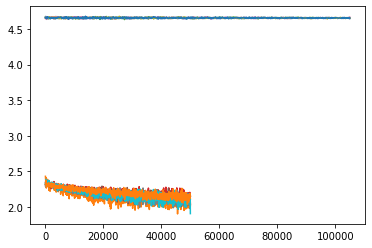

In [48]:
results = []
for dataset_name in dataset_names:
    print('-'*50, 'pretraining', '-'*50)
    train_loader_random_lebels = dataloader_pretraining_gray(dataset_name)

    model = Net(105)
    optimizer = optim.SGD(model.parameters(), lr=wandb.config.learning_rate)
    train_losses, val_losses, exemplars = train(model, optimizer, train_loader_random_lebels)
    plt.plot(exemplars, train_losses)

    save_pruned_model(model, f"models/pretrained_gray_{dataset_name}_withoutlast.pt")

    newModel = Net(10)
    optimizer = optim.SGD(newModel.parameters(), lr=0.1)
    newModel.load_state_dict(torch.load(f"models/pretrained_gray_{dataset_name}_withoutlast.pt"), strict=False)

    for idx, child in enumerate(newModel.children()):
        if idx == len(list(newModel.children())) - 1:
            break
        for param in child.parameters():
            param.requires_grad = False

    print('-'*50, 'training only last layer', '-'*50)
    train_loader, val_loader, test_loader = MNIST()

    train_losses, val_losses, exemplars = train(newModel, optimizer, train_loader)
    plt.plot(exemplars, train_losses)
    acc = test(newModel, test_loader)
    results.append({"dataset_name": dataset_name, "accuracy": acc})

In [ ]:
import pandas as pd
df = pd.DataFrame(results)
vals = []

for ac in df['accuracy']:
    vals.append(ac.numpy())

df['accuracy'] = np.array(vals)

df.sort_values('accuracy')

In [47]:
import pandas as pd
df = pd.DataFrame(results)
vals = []

for ac in df['accuracy']:
    vals.append(ac.numpy())

df['accuracy'] = np.array(vals)

df.sort_values('accuracy')


,dataset_name,accuracy
0,dead_leaves-mixed,31.910000
6,stat-spectrum_color_wmm,43.740002
9,stylegan-random,50.240002
7,stat-wmm,51.130001
4,stat-spectrum,53.930000
5,stat-spectrum_color,55.040001
1,dead_leaves-oriented,55.560001
8,stylegan-highfreq,56.520000
2,dead_leaves-squares,59.580002
3,dead_leaves-textures,64.720001
